##### import libary

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
import utility
import importlib
import time
importlib.reload(utility)
pd.set_option('mode.chained_assignment', None)

##### This analysis use fitness info sheet and generation wise allele count information sheet for each unique mutation from ecoli metasheet.

Generation wise fitness information --> Available in Fitness2_experimental sheet of ecoli metadata
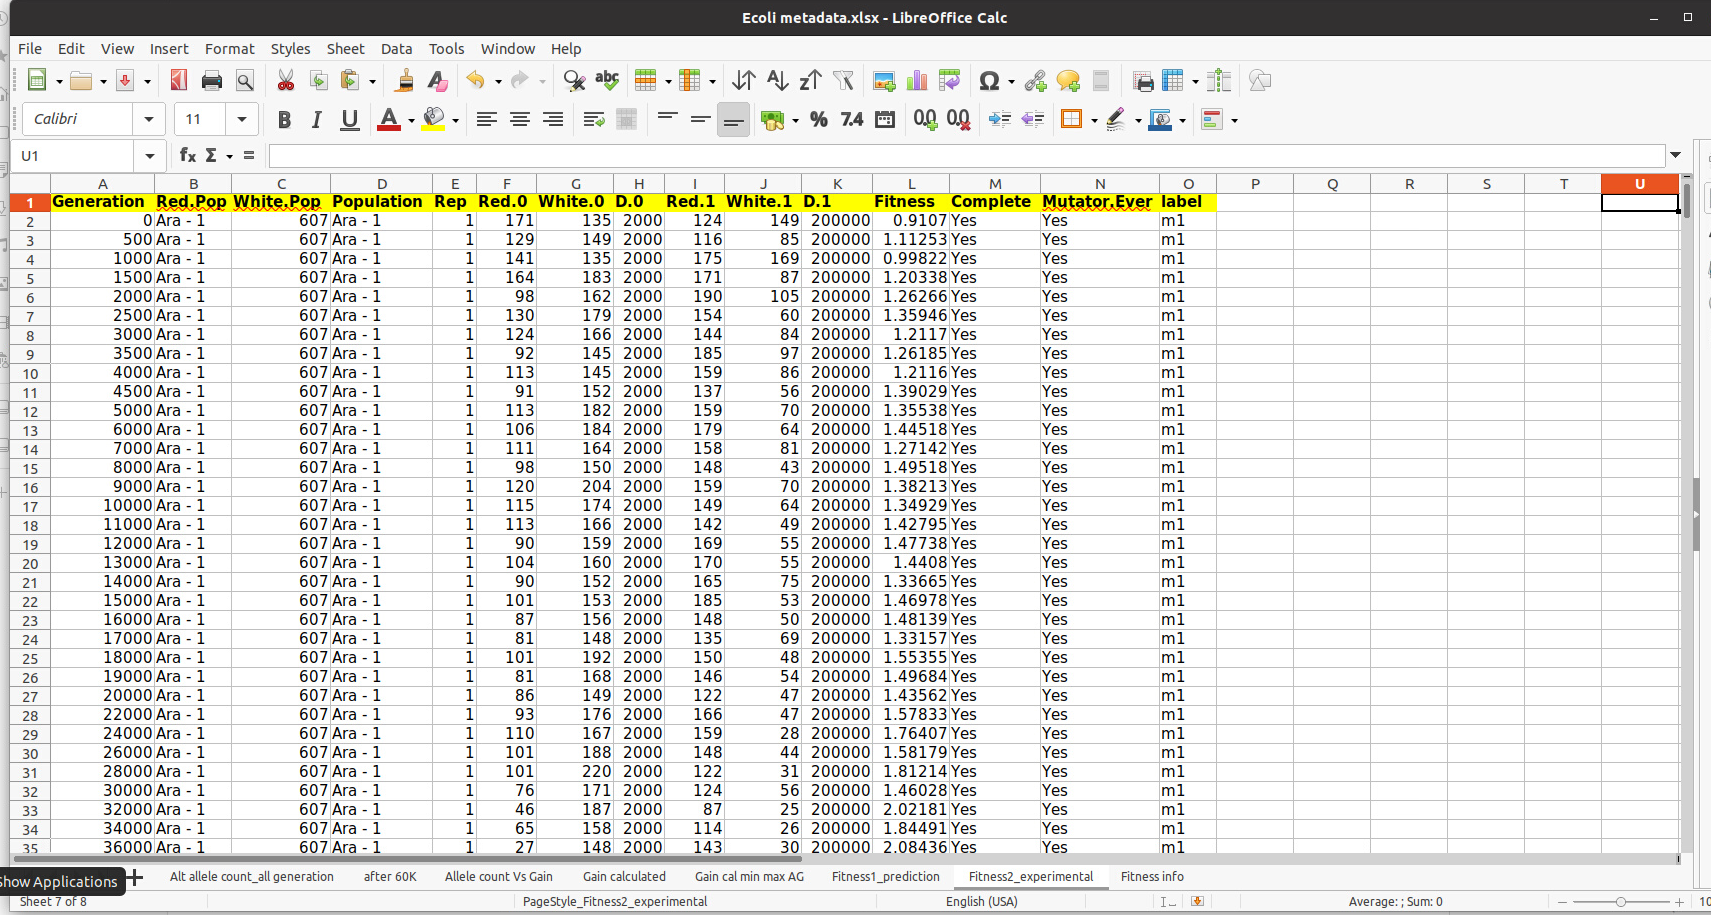

Generation wise allele count information --> Available in Alt allele count_all generation sheet of ecoli metadata
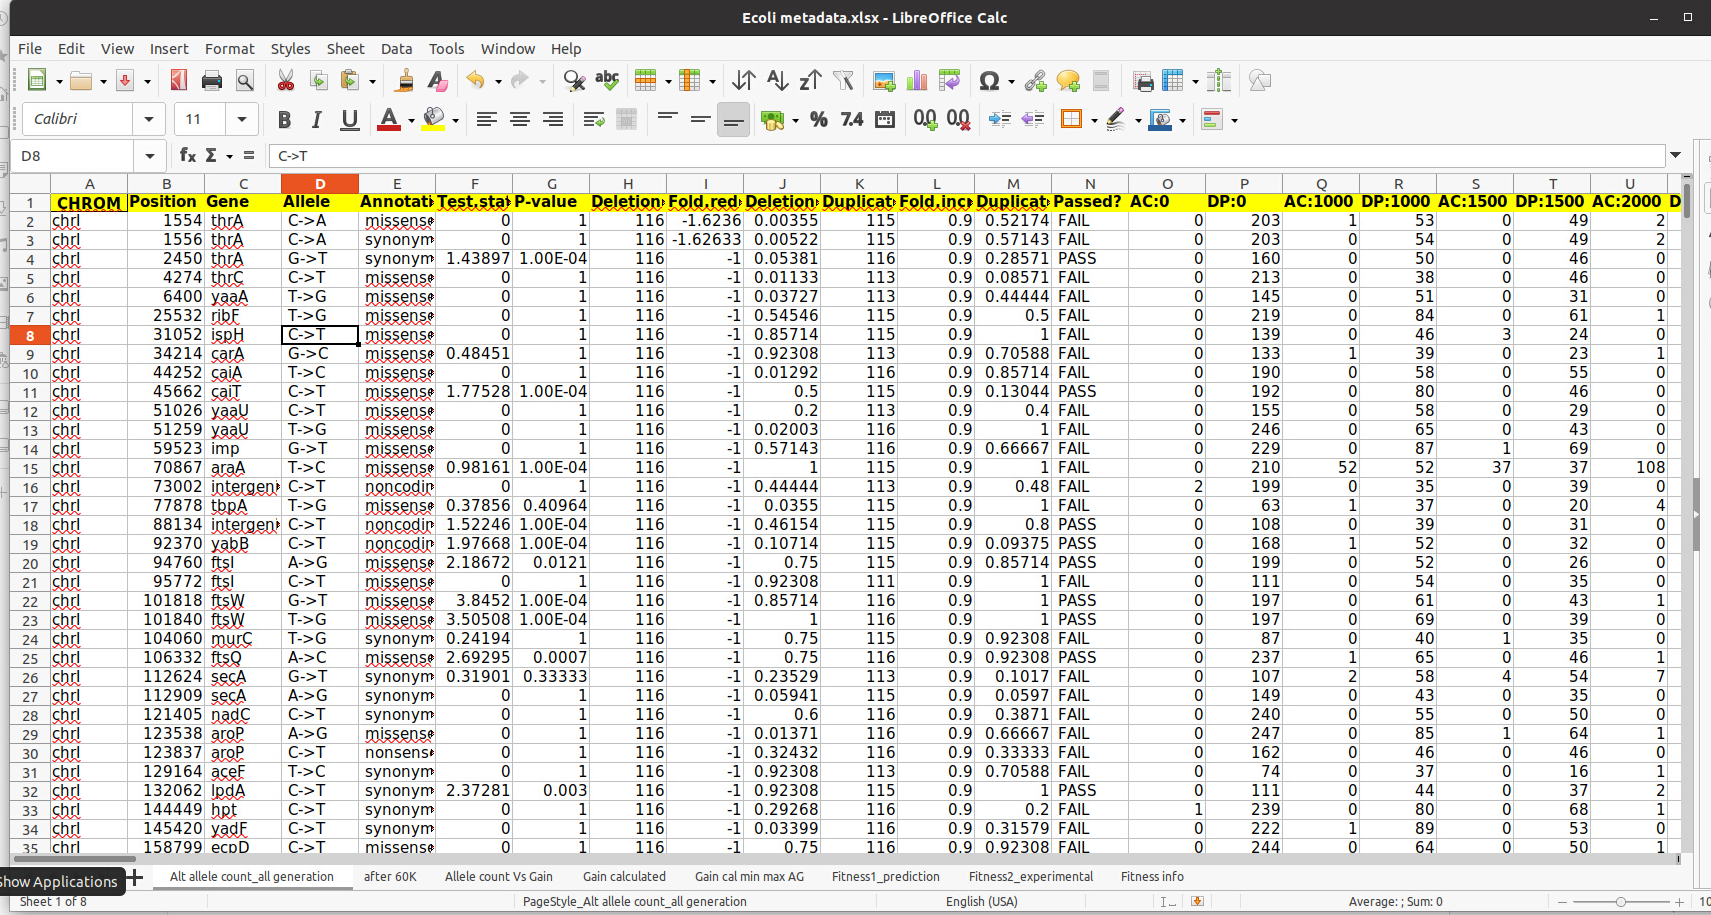

Gain information --> Available in Gain calculated sheet of ecoli metadata
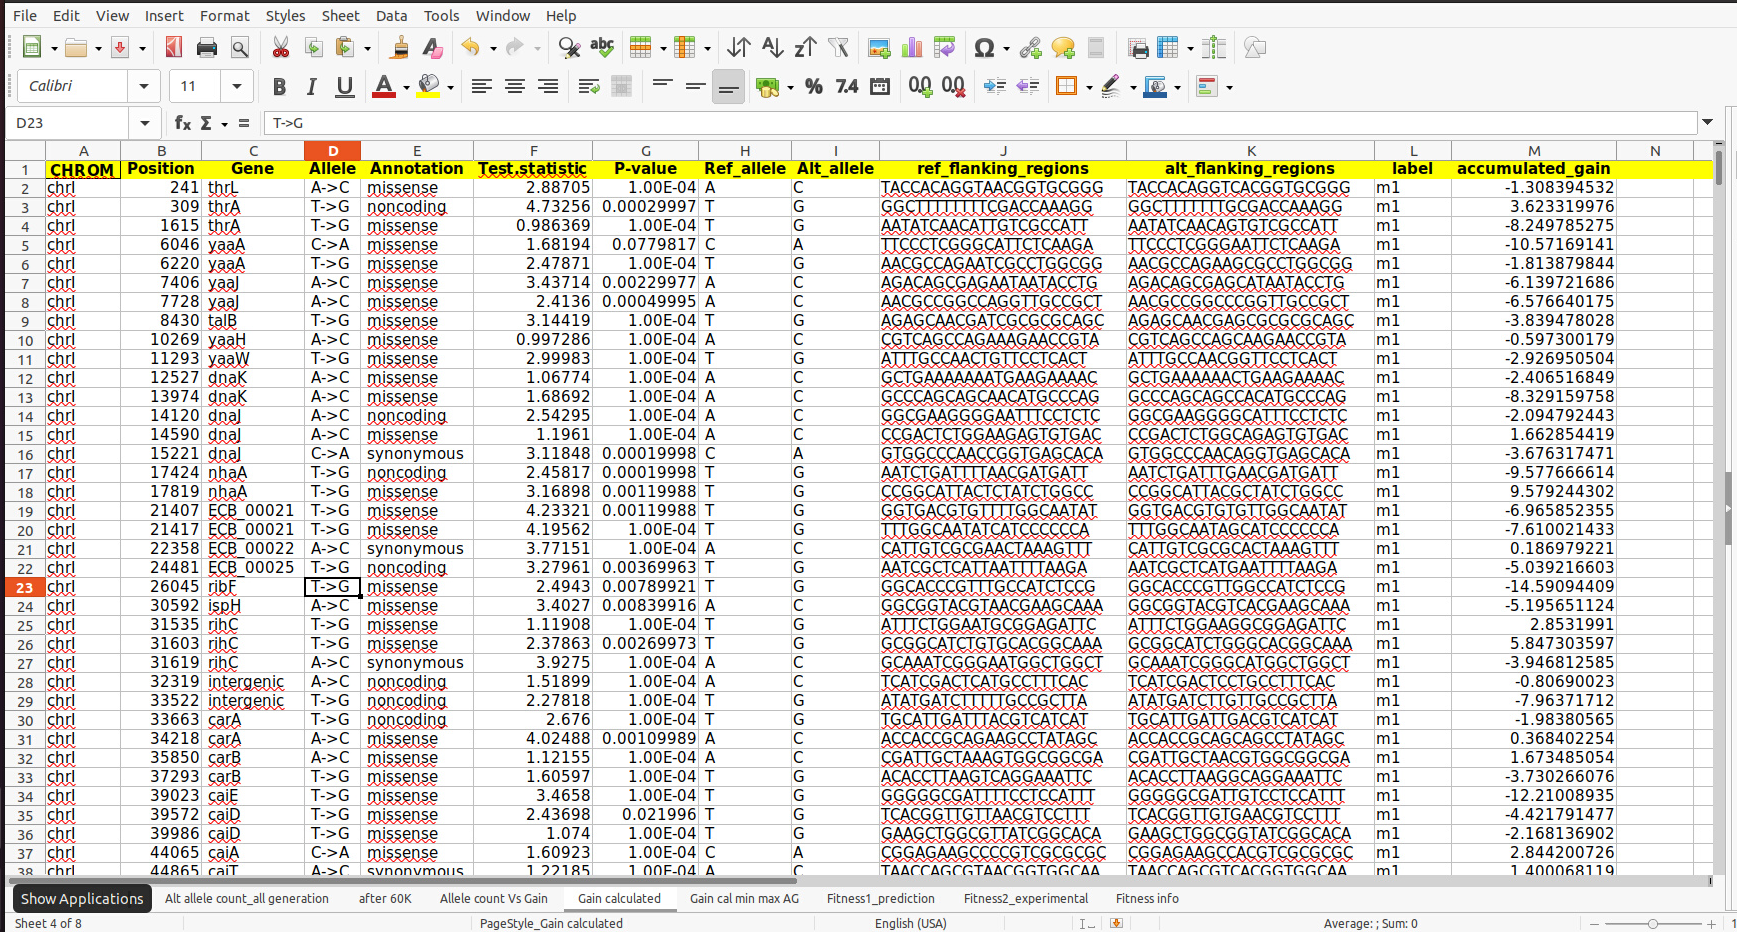

##### Read fitness data from metadata

In [7]:
df_Fitness2_experimental = pd.read_excel("Ecoli metadata.xlsx", sheet_name="Fitness2_experimental")
df_Fitness2_experimental = df_Fitness2_experimental.rename(columns={'label ': 'label'})
df_Fitness2_experimental.head()

Generation  Red.Pop White.Pop Population  Rep  Red.0  White.0   D.0  Red.1  \
0           0  Ara - 1       607    Ara - 1    1  171.0    135.0  2000  124.0   
1         500  Ara - 1       607    Ara - 1    1  129.0    149.0  2000  116.0   
2        1000  Ara - 1       607    Ara - 1    1  141.0    135.0  2000  175.0   
3        1500  Ara - 1       607    Ara - 1    1  164.0    183.0  2000  171.0   
4        2000  Ara - 1       607    Ara - 1    1   98.0    162.0  2000  190.0   

   White.1     D.1   Fitness Complete Mutator.Ever label  
0    149.0  200000  0.910700      Yes          Yes    m1  
1     85.0  200000  1.112534      Yes          Yes    m1  
2    169.0  200000  0.998220      Yes          Yes    m1  
3     87.0  200000  1.203381      Yes          Yes    m1  
4    105.0  200000  1.262659      Yes          Yes    m1

##### check if any duplicate row is present in fitness sheet

In [8]:
df_Fitness2_experimental[df_Fitness2_experimental.duplicated()] # No duplicate row found

Empty DataFrame
Columns: [Generation, Red.Pop, White.Pop, Population, Rep, Red.0, White.0, D.0, Red.1, White.1, D.1, Fitness, Complete, Mutator.Ever, label]
Index: []

##### Read gain sheet data

In [9]:
df_Gain_calculated = pd.read_excel("Ecoli metadata.xlsx", sheet_name= "Gain calculated")

In [10]:
df_Gain_calculated

CHROM  Position         Gene Allele   Annotation  Test.statistic  \
0      chrI       241         thrL   A->C     missense        2.887050   
1      chrI       309         thrA   T->G    noncoding        4.732560   
2      chrI      1615         thrA   T->G     missense        0.986369   
3      chrI      6046         yaaA   C->A     missense        1.681940   
4      chrI      6220         yaaA   T->G     missense        2.478710   
...     ...       ...          ...    ...          ...             ...   
36918  chrI   4628507         arcA   A->G    noncoding        1.517100   
36919  chrI   4628701         yjjY   A->C     missense        5.263680   
36920  chrI   4628934   intergenic   T->G    noncoding        2.440750   
36921  chrI   4629227         lasT   A->C   synonymous        2.469960   
36922  chrI   4629600         lasT   A->G     missense        1.506350   

        P-value Ref_allele Alt_allele   ref_flanking_regions  \
0      0.000100          A          C  TACCACAGGTAACGGTGCGGG   
1      0.000300          T          G  GGCTTTTTTTTCGACCAAAGG   
2      0.000100          T          G  AATATCAACATTGTCGCCATT   
3      0.077982          C          A  TTCCCTCGGGCATTCTCAAGA   
4      0.000100          T          G  AACGCCAGAATCGCCTGGCGG   
...         ...        ...        ...                    ...   
36918  0.000500          A          G  AACAGGAAGTACAAAAGTCCC   
36919  0.000100          A          C  ACAGCAACATAACAGGCTAAG   
36920  0.000100          T          G  ATATGTAGCATTTTTTAACAA   
36921  0.024268          A          C  ACCTGGAGCCAGCCACCCGCT   
36922  0.000100          A          G  GAAAAGTGACACAACGGCAGA   

        alt_flanking_regions label  accumulated_gain  
0      TACCACAGGTCACGGTGCGGG    m1         -1.308395  
1      GGCTTTTTTTGCGACCAAAGG    m1          3.623320  
2      AATATCAACAGTGTCGCCATT    m1         -8.249785  
3      TTCCCTCGGGAATTCTCAAGA    m1        -10.571691  
4      AACGCCAGAAGCGCCTGGCGG    m1         -1.813880  
...                      ...   ...               ...  
36918  AACAGGAAGTGCAAAAGTCCC    p6          3.294695  
36919  ACAGCAACATCACAGGCTAAG    p6         -0.338674  
36920  ATATGTAGCAGTTTTTAACAA    p6         -0.579049  
36921  ACCTGGAGCCCGCCACCCGCT    p6         -5.968448  
36922  GAAAAGTGACGCAACGGCAGA    p6          6.417872  

[36923 rows x 13 columns]

##### check for duplicate w.r.t Chromosome, Position, Gene,Allele, Annotation, Reference allele, Alternate allele,label in the gain sheet

In [11]:
df_Gain_calculated[df_Gain_calculated.duplicated(subset=['CHROM','Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

CHROM  Position   Gene Allele Annotation  Test.statistic   P-value  \
19663  chrI    450000   ylaB   A->G   missense         1.90955  0.018633   

      Ref_allele Alt_allele   ref_flanking_regions   alt_flanking_regions  \
19663          A          G  GTTGAAGCCCAGGTGATGATC  GTTGAAGCCCGGGTGATGATC   

      label  accumulated_gain  
19663    p3         -6.546367

##### Drop duplicates from the gain sheet

In [12]:
df_Gain_calculated.drop_duplicates(subset=['CHROM','Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Gain_calculated.reset_index(inplace=True, drop=True)
df_Gain_calculated.head()

CHROM  Position   Gene Allele  Annotation  Test.statistic   P-value  \
0  chrI       241   thrL   A->C    missense        2.887050  0.000100   
1  chrI       309   thrA   T->G   noncoding        4.732560  0.000300   
2  chrI      1615   thrA   T->G    missense        0.986369  0.000100   
3  chrI      6046   yaaA   C->A    missense        1.681940  0.077982   
4  chrI      6220   yaaA   T->G    missense        2.478710  0.000100   

  Ref_allele Alt_allele   ref_flanking_regions   alt_flanking_regions label  \
0          A          C  TACCACAGGTAACGGTGCGGG  TACCACAGGTCACGGTGCGGG    m1   
1          T          G  GGCTTTTTTTTCGACCAAAGG  GGCTTTTTTTGCGACCAAAGG    m1   
2          T          G  AATATCAACATTGTCGCCATT  AATATCAACAGTGTCGCCATT    m1   
3          C          A  TTCCCTCGGGCATTCTCAAGA  TTCCCTCGGGAATTCTCAAGA    m1   
4          T          G  AACGCCAGAATCGCCTGGCGG  AACGCCAGAAGCGCCTGGCGG    m1   

   accumulated_gain  
0         -1.308395  
1          3.623320  
2         -8.249785  
3        -10.571691  
4         -1.813880

##### Read allele count and generation data from metasheet

In [13]:
df_Alt_allele_count_all_generation = pd.read_excel("Ecoli metadata.xlsx", sheet_name= "Alt allele count_all generation")
df_Alt_allele_count_all_generation.head()

CHROM  Position   Gene Allele   Annotation  Test.statistic  P-value  \
0  chrI      1554   thrA   C->A     missense         0.00000   1.0000   
1  chrI      1556   thrA   C->A   synonymous         0.00000   1.0000   
2  chrI      2450   thrA   G->T   synonymous         1.43897   0.0001   
3  chrI      4274   thrC   C->T     missense         0.00000   1.0000   
4  chrI      6400   yaaA   T->G     missense         0.00000   1.0000   

   Deletion.index  Fold.reduction  Deletion.P-value  ...  DP:58500  AC:59000  \
0             116        -1.62360          0.003545  ...     154.0       1.0   
1             116        -1.62633          0.005224  ...     150.0       0.0   
2             116        -1.00000          0.053812  ...     129.0       4.0   
3             116        -1.00000          0.011331  ...      97.0       0.0   
4             116        -1.00000          0.037267  ...      67.0       0.0   

   DP:59000 AC:59500  DP:59500  AC:60000  DP:60000  Ref_allele  Alt_allele  \
0       5.0      0.0      77.0       0.0       4.0           C           A   
1       6.0      0.0      76.0       0.0       4.0           C           A   
2       4.0     67.0      67.0       8.0       8.0           G           T   
3       2.0      0.0      52.0       0.0       3.0           C           T   
4       2.0      0.0      45.0       0.0       5.0           T           G   

   label  
0     p1  
1     p1  
2     p1  
3     p1  
4     p1  

[5 rows x 251 columns]

##### delete duplicate row in df_Alt_allele_count_all_generation dataframe where duplicate indicate when ['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'] are same in mutiple row

In [14]:
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
df_Alt_allele_count_all_generation.head()

CHROM  Position   Gene Allele   Annotation  Test.statistic  P-value  \
0  chrI      1554   thrA   C->A     missense         0.00000   1.0000   
1  chrI      1556   thrA   C->A   synonymous         0.00000   1.0000   
2  chrI      2450   thrA   G->T   synonymous         1.43897   0.0001   
3  chrI      4274   thrC   C->T     missense         0.00000   1.0000   
4  chrI      6400   yaaA   T->G     missense         0.00000   1.0000   

   Deletion.index  Fold.reduction  Deletion.P-value  ...  DP:58500  AC:59000  \
0             116        -1.62360          0.003545  ...     154.0       1.0   
1             116        -1.62633          0.005224  ...     150.0       0.0   
2             116        -1.00000          0.053812  ...     129.0       4.0   
3             116        -1.00000          0.011331  ...      97.0       0.0   
4             116        -1.00000          0.037267  ...      67.0       0.0   

   DP:59000 AC:59500  DP:59500  AC:60000  DP:60000  Ref_allele  Alt_allele  \
0       5.0      0.0      77.0       0.0       4.0           C           A   
1       6.0      0.0      76.0       0.0       4.0           C           A   
2       4.0     67.0      67.0       8.0       8.0           G           T   
3       2.0      0.0      52.0       0.0       3.0           C           T   
4       2.0      0.0      45.0       0.0       5.0           T           G   

   label  
0     p1  
1     p1  
2     p1  
3     p1  
4     p1  

[5 rows x 251 columns]

#### Read esm score sheet available from previous analysis

In [15]:
df_esm = pd.read_excel("DNA_PRT_Ecolimeta_true_SNP_prt_mapped_esm1b_score_fresh_compl.xlsx")
# df_esm = pd.read_excel("/home/abhishekh/Downloads/Final_esm1b_variant.xlsx")
df_esm.head()

Position  Gene Allele Ref_allele Alt_allele Annotation label  Start    End  \
0       241  thrL   A->C          A          C   missense    m1    190    255   
1      1615  thrA   T->G          T          G   missense    m1    336   2798   
2      8430  talB   T->G          T          G   missense    m1   8236   9189   
3     12527  dnaK   A->C          A          C   missense    m1  12161  14077   
4     13974  dnaK   A->C          A          C   missense    m1  12161  14077   

  Strand  ... has_space                                        WT_aa_made2  \
0      +  ...     False                              MKRISTTITTTITITTGNGAG   
1      +  ...     False  MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...   
2      +  ...     False  MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...   
3      +  ...     False  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...   
4      +  ...     False  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...   

  comparison2                                        Mut_aa_made    SNP  \
0        True                              MKRISTTITTTITITTGHGAG   N18H   
1        True  MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...  I427S   
2        True  MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...   D65E   
3        True  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...  M123L   
4        True  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...  Q605P   

     seq_id_x      universal_id    seq_id_y  mut_name  esm_score  
0    241_thrL     241_thrL_N18H    241_thrL      N18H  -4.279933  
1   1615_thrA   1615_thrA_I427S   1615_thrA     I427S -11.530375  
2   8430_talB    8430_talB_D65E   8430_talB      D65E  -5.331029  
3  12527_dnaK  12527_dnaK_M123L  12527_dnaK     M123L  -4.669276  
4  13974_dnaK  13974_dnaK_Q605P  13974_dnaK     Q605P  -7.992450  

[5 rows x 26 columns]

##### delete duplicate row from esm dataframe where duplicate indicate when ["Position",  "Gene", "label", "Allele"] are same in mutiple row

In [16]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates.head()

Position  Gene label  esm_score Allele
0       241  thrL    m1  -4.279933   A->C
1      1615  thrA    m1 -11.530375   T->G
2      8430  talB    m1  -5.331029   T->G
3     12527  dnaK    m1  -4.669276   A->C
4     13974  dnaK    m1  -7.992450   A->C

##### Merge gain dataframe and allele dataframe

In [17]:
df_complete = pd.merge(df_Alt_allele_count_all_generation, df_Gain_calculated, on=['CHROM',
 'Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")
df_complete

CHROM  Position   Gene Allele   Annotation  Test.statistic_x  P-value_x  \
0      chrI      1554   thrA   C->A     missense          0.000000     1.0000   
1      chrI      1556   thrA   C->A   synonymous          0.000000     1.0000   
2      chrI      2450   thrA   G->T   synonymous          1.438970     0.0001   
3      chrI      4274   thrC   C->T     missense          0.000000     1.0000   
4      chrI      6400   yaaA   T->G     missense          0.000000     1.0000   
...     ...       ...    ...    ...          ...               ...        ...   
36917  chrI   4509212   sgcC   C->T   synonymous          0.000000     1.0000   
36918  chrI   4532106   gntP   C->T   synonymous          0.000000     1.0000   
36919  chrI   4533490   uxuA   C->T     missense          0.000000     1.0000   
36920  chrI   4606154   yjjI   C->T     missense          0.000000     1.0000   
36921  chrI   4615842   nadR   A->T     missense          0.988406     0.0001   

       Deletion.index  Fold.reduction  Deletion.P-value  ...  AC:60000  \
0                 116        -1.62360          0.003545  ...       0.0   
1                 116        -1.62633          0.005224  ...       0.0   
2                 116        -1.00000          0.053812  ...       8.0   
3                 116        -1.00000          0.011331  ...       0.0   
4                 116        -1.00000          0.037267  ...       0.0   
...               ...             ...               ...  ...       ...   
36917             120        -1.00000          0.292683  ...       0.0   
36918             120        -1.00000          0.521739  ...       0.0   
36919             120        -1.00000          0.705882  ...       1.0   
36920             120        -1.00000          0.179104  ...       0.0   
36921             120        -1.00000          0.750000  ...      73.0   

       DP:60000  Ref_allele Alt_allele  label  Test.statistic_y  P-value_y  \
0           4.0           C          A     p1          0.000000     1.0000   
1           4.0           C          A     p1          0.000000     1.0000   
2           8.0           G          T     p1          1.438970     0.0001   
3           3.0           C          T     p1          0.000000     1.0000   
4           5.0           T          G     p1          0.000000     1.0000   
...         ...         ...        ...    ...               ...        ...   
36917      44.0           C          T     m6          0.000000     1.0000   
36918      60.0           C          T     m6          0.000000     1.0000   
36919      79.0           C          T     m6          0.000000     1.0000   
36920      41.0           C          T     m6          0.000000     1.0000   
36921      73.0           A          T     m6          0.988406     0.0001   

        ref_flanking_regions   alt_flanking_regions  accumulated_gain  
0      TGATGGTATGCGCACCTTGCG  TGATGGTATGAGCACCTTGCG         -5.434794  
1      ATGGTATGCGCACCTTGCGTG  ATGGTATGCGAACCTTGCGTG         -6.463767  
2      AACCTGTGCTGCCCGCAGAGT  AACCTGTGCTTCCCGCAGAGT         -2.942253  
3      GAAACTGTTGCCATCGACGGC  GAAACTGTTGTCATCGACGGC         -7.823651  
4      GTATAGCGCGTGGTGGTCAAC  GTATAGCGCGGGGTGGTCAAC        -11.175249  
...                      ...                    ...               ...  
36917  CTGAGATTTGCGCACTTTCAC  CTGAGATTTGTGCACTTTCAC         -6.535374  
36918  CGACGGACAGCGCCGCCACCA  CGACGGACAGTGCCGCCACCA         -5.472303  
36919  TTCCACGAAGCGGCGCACCTG  TTCCACGAAGTGGCGCACCTG         -2.578430  
36920  CAGCGCGCGGCGGGCTTCGGC  CAGCGCGCGGTGGGCTTCGGC         -3.938429  
36921  GATACCCGCGATCGCGCGTTG  GATACCCGCGTTCGCGCGTTG         -4.966243  

[36922 rows x 256 columns]

#### extract the column relavent for current analysis from allele count dataframe (all the generation wise allele count, 'CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label')

In [18]:
filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

AC:0  AC:1000  AC:1500  AC:2000  AC:2500  AC:3000  AC:4000  AC:4500  \
0     0        1        0        2      1.0        1        0        0   
1     0        0        0        2      0.0        3        0        0   
2     0        0        0        0      0.0        0        0        0   
3     0        0        0        0      0.0        1        0        0   
4     0        0        0        0      2.0        0        0        0   

   AC:5000  AC:5500  ...  AC:60000  CHROM  Position   Gene  Allele  \
0        0        0  ...       0.0   chrI      1554   thrA    C->A   
1        0        0  ...       0.0   chrI      1556   thrA    C->A   
2        0        0  ...       8.0   chrI      2450   thrA    G->T   
3        0        0  ...       0.0   chrI      4274   thrC    C->T   
4        0        0  ...       0.0   chrI      6400   yaaA    T->G   

    Annotation  Ref_allele  Alt_allele  label  accumulated_gain  
0     missense           C           A     p1         -5.434794  
1   synonymous           C           A     p1         -6.463767  
2   synonymous           G           T     p1         -2.942253  
3     missense           C           T     p1         -7.823651  
4     missense           T           G     p1        -11.175249  

[5 rows x 126 columns]

##### Define mutator and non mutator population

In [19]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

#### population wise mutation count
###### It shows the count of mutation for every population. It is evident from the counts that  the mutator has significantly higher number of mutation than non mutator.

In [20]:
print("The number of mutation present population wise :")
df_complete["label"].value_counts()

The number of mutation present population wise :


p6    11257
p3     5967
m1     4994
m4     4953
m2     3398
m3     3215
p1      957
m5      600
m6      475
p4      420
p5      355
p2      331
Name: label, dtype: int64

##### find the generations which have missing value

In [21]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\nNumber of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


#### drop the generations having having nan value

In [22]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

AC:0  AC:1000  AC:1500  AC:2000  AC:3000  AC:4000  AC:4500  AC:5000  \
0     0        1        0        2        1        0        0        0   
1     0        0        0        2        3        0        0        0   
2     0        0        0        0        0        0        0        0   
3     0        0        0        0        1        0        0        0   
4     0        0        0        0        0        0        0        0   

   AC:5500  AC:6000  ...  AC:57500  CHROM  Position   Gene  Allele  \
0        0        0  ...         0   chrI      1554   thrA    C->A   
1        0        0  ...         0   chrI      1556   thrA    C->A   
2        0        0  ...        41   chrI      2450   thrA    G->T   
3        0        0  ...         0   chrI      4274   thrC    C->T   
4        0        0  ...         0   chrI      6400   yaaA    T->G   

    Annotation  Ref_allele  Alt_allele  label  accumulated_gain  
0     missense           C           A     p1         -5.434794  
1   synonymous           C           A     p1         -6.463767  
2   synonymous           G           T     p1         -2.942253  
3     missense           C           T     p1         -7.823651  
4     missense           T           G     p1        -11.175249  

[5 rows x 118 columns]

##### create dataset having all mutation info in proper form for easy calculation
##### Make a dataframe having column ['label', 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation', 'generation', 'allele count', 'generation_number']

In [23]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-9]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
all_mutation.head()

label CHROM  Position         Gene Allele   Annotation generation        AG  \
0    p1  chrI     73002   intergenic   C->T    noncoding       AC:0 -8.614562   
1    p1  chrI    144449          hpt   C->T   synonymous       AC:0 -7.918810   
2    p1  chrI    458736         kefA   C->T     missense       AC:0 -8.988104   
3    p1  chrI    524856         purE   G->A     missense       AC:0 -2.894726   
4    p1  chrI    557008    ECB_00513   C->T     missense       AC:0 -9.498170   

   allele count  generation_number  
0             2                  0  
1             1                  0  
2             1                  0  
3             1                  0  
4             2                  0

In [24]:
all_mutation

label CHROM  Position         Gene Allele   Annotation generation  \
0          p1  chrI     73002   intergenic   C->T    noncoding       AC:0   
1          p1  chrI    144449          hpt   C->T   synonymous       AC:0   
2          p1  chrI    458736         kefA   C->T     missense       AC:0   
3          p1  chrI    524856         purE   G->A     missense       AC:0   
4          p1  chrI    557008    ECB_00513   C->T     missense       AC:0   
...       ...   ...       ...          ...    ...          ...        ...   
1048642    m6  chrI   4455560         pyrB   T->C     missense   AC:57500   
1048643    m6  chrI   4455572         pyrB   T->G     missense   AC:57500   
1048644    m6  chrI   4455586         pyrB   C->T   synonymous   AC:57500   
1048645    m6  chrI   4504890    ECB_04162   C->A    noncoding   AC:57500   
1048646    m6  chrI   4615842         nadR   A->T     missense   AC:57500   

               AG  allele count  generation_number  
0       -8.614562             2                  0  
1       -7.918810             1                  0  
2       -8.988104             1                  0  
3       -2.894726             1                  0  
4       -9.498170             2                  0  
...           ...           ...                ...  
1048642 -3.836044             1              57500  
1048643 -8.814852             6              57500  
1048644  1.786326             1              57500  
1048645 -0.194179            96              57500  
1048646 -4.966243           111              57500  

[1048647 rows x 10 columns]

##### remove white spaces from the columns of dataframes

In [25]:
df_esm_no_duplicates["Gene"] = df_esm_no_duplicates["Gene"] .str.strip()
all_mutation["Gene"] = all_mutation["Gene"] .str.strip()
df_esm_no_duplicates["Allele"] = df_esm_no_duplicates["Allele"] .str.strip()
all_mutation["Allele"] = all_mutation["Allele"] .str.strip()

#### merge esm score and allele count sheet in single dataframe

In [26]:
all_mutation_with_esm_1b_score = pd.merge(all_mutation, df_esm_no_duplicates, on = ["label", 'Position', "Gene", 'Allele'], how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

label CHROM  Position  Gene Allele Annotation generation        AG  \
0    p1  chrI    458736  kefA   C->T   missense       AC:0 -8.988104   
1    p1  chrI    524856  purE   G->A   missense       AC:0 -2.894726   
2    p1  chrI   1156229   rne   G->A   missense       AC:0 -6.276873   
3    p1  chrI   1507395  ydcE   A->G   missense       AC:0 -1.912514   
4    p1  chrI   2538060  yfgC   G->A   missense       AC:0 -7.050116   

   allele count  generation_number  esm_score  
0             1                  0  -6.072133  
1             1                  0 -12.324469  
2             1                  0  -3.581650  
3             1                  0  -5.345155  
4             1                  0 -11.184139

#### assign mutator/ non mutator tag against each mutation as per population

In [27]:
for i in range(all_mutation_with_esm_1b_score_drop_na.shape[0]):
    
    if all_mutation_with_esm_1b_score_drop_na.loc[i, "label"] in mutator_list:
        all_mutation_with_esm_1b_score_drop_na.loc[i, "mutator"] = "mutator"
    if all_mutation_with_esm_1b_score_drop_na.loc[i, "label"] in non_mutator_list:
        all_mutation_with_esm_1b_score_drop_na.loc[i, "mutator"] = "non mutator"
all_mutation_with_esm_1b_score_drop_na.head()

label CHROM  Position  Gene Allele Annotation generation        AG  \
0    p1  chrI    458736  kefA   C->T   missense       AC:0 -8.988104   
1    p1  chrI    524856  purE   G->A   missense       AC:0 -2.894726   
2    p1  chrI   1156229   rne   G->A   missense       AC:0 -6.276873   
3    p1  chrI   1507395  ydcE   A->G   missense       AC:0 -1.912514   
4    p1  chrI   2538060  yfgC   G->A   missense       AC:0 -7.050116   

   allele count  generation_number  esm_score      mutator  
0             1                  0  -6.072133  non mutator  
1             1                  0 -12.324469  non mutator  
2             1                  0  -3.581650  non mutator  
3             1                  0  -5.345155  non mutator  
4             1                  0 -11.184139  non mutator

##### esm score vs generation for all type of population
###### It is the line plots showing median esm scores associated with mutations (with a shaded area indicating the 95% confidence interval) for mutators, non-mutators, and their combination (Good et al. 2017). The mutator group consistently shows an upward trend in median LLR scores, while the non-mutator group exhibits a minor increase in median LLR scores towards the end of the trajectory, with substantial intermittent fluctuations. Mutators and non-mutators, when combined, show a steady increase in median LLR scores. Combining mutators and non-mutators reveals a steady rise in median LLR scores, primarily due to the significantly higher mutation frequency in mutators.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(5.0833333333333215, 0.5, 'Median LLR score')

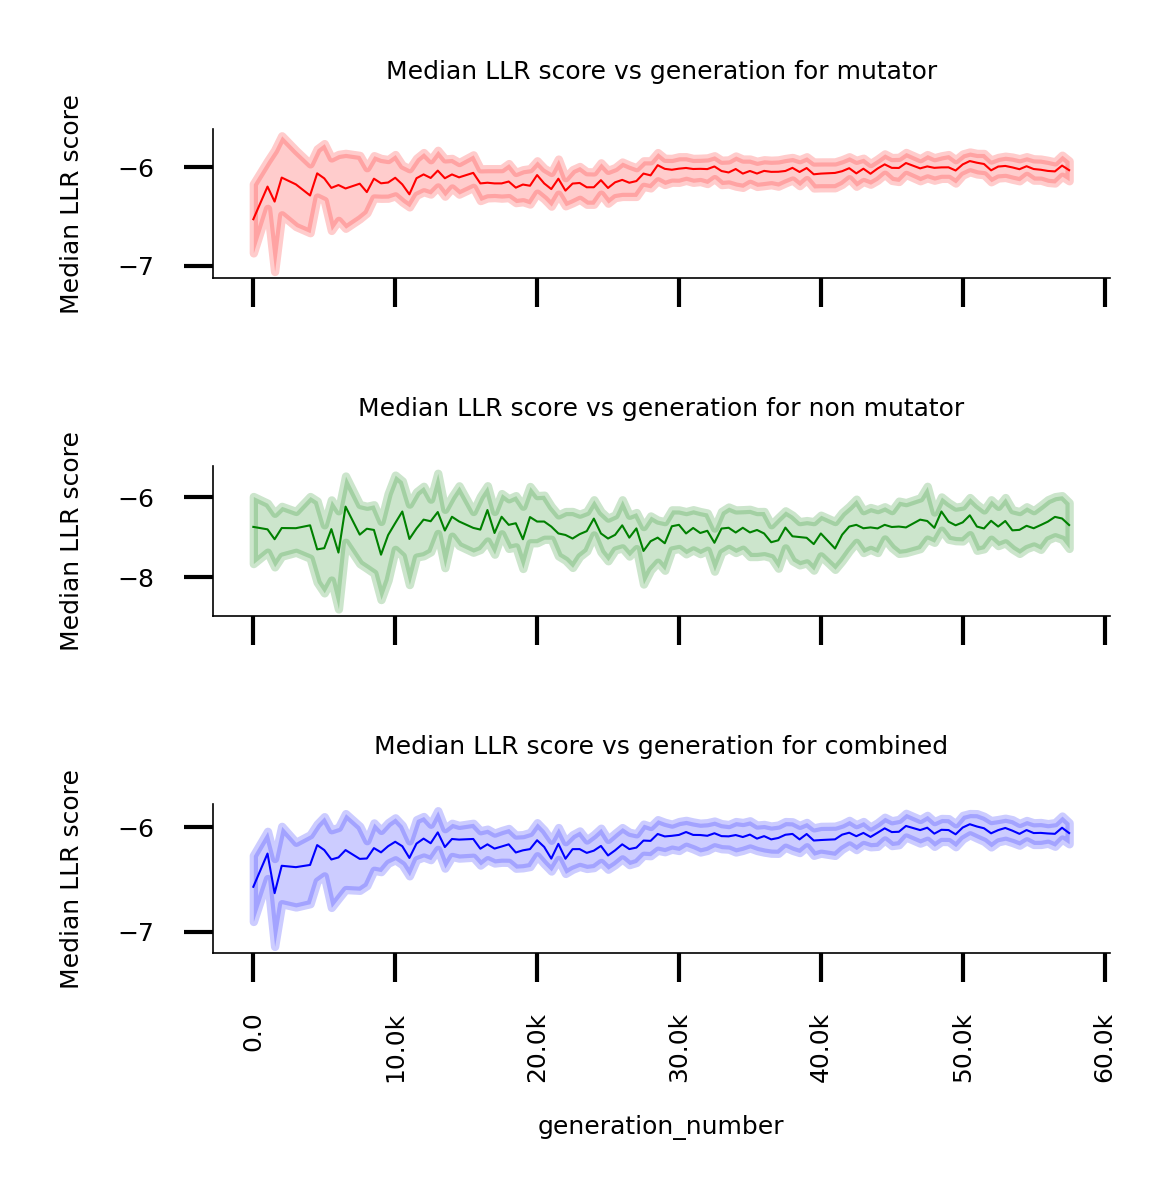

In [28]:
ax = utility.return_mutator_non_mutator_column_name_wise_graph_together(all_mutation_with_esm_1b_score_drop_na, mutator_list, non_mutator_list, column_name = "esm_score", fontsize = 3);
ax[0].set_title("Median LLR score vs generation for mutator", fontsize = 3)
ax[1].set_title("Median LLR score vs generation for non mutator", fontsize = 3)
ax[2].set_title("Median LLR score vs generation for combined", fontsize = 3)
ax[0].set_ylabel("Median LLR score", fontsize = 3)
ax[1].set_ylabel("Median LLR score", fontsize = 3)
ax[2].set_ylabel("Median LLR score", fontsize = 3)

##### calculate generation wise median of fitnesss and esm score for overall population, mutator, non mutator 

In [29]:
all_population_combined_esm_fitness_median = utility.return_combined_fitness_esm_data(df_Fitness2_experimental, all_mutation_with_esm_1b_score_drop_na)

mutator_population_combined_esm_fitness_median =  utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="Yes"], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na.loc[:, "mutator"]=="mutator"] )

non_mutator_population_combined_esm_fitness_median =   utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="No"], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na.loc[:, "mutator"]=="non mutator"] )

##### Make a scatterplot of median esm vs median fitness for overall population, mutator, non mutator 
###### It is the scatter plot that shows the association between median fitness and median LLR score across generations for the different group. The color gradient depicts generation chronology.

/tmp/ipykernel_3772157/1147969635.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[0].figure.colorbar(sm)


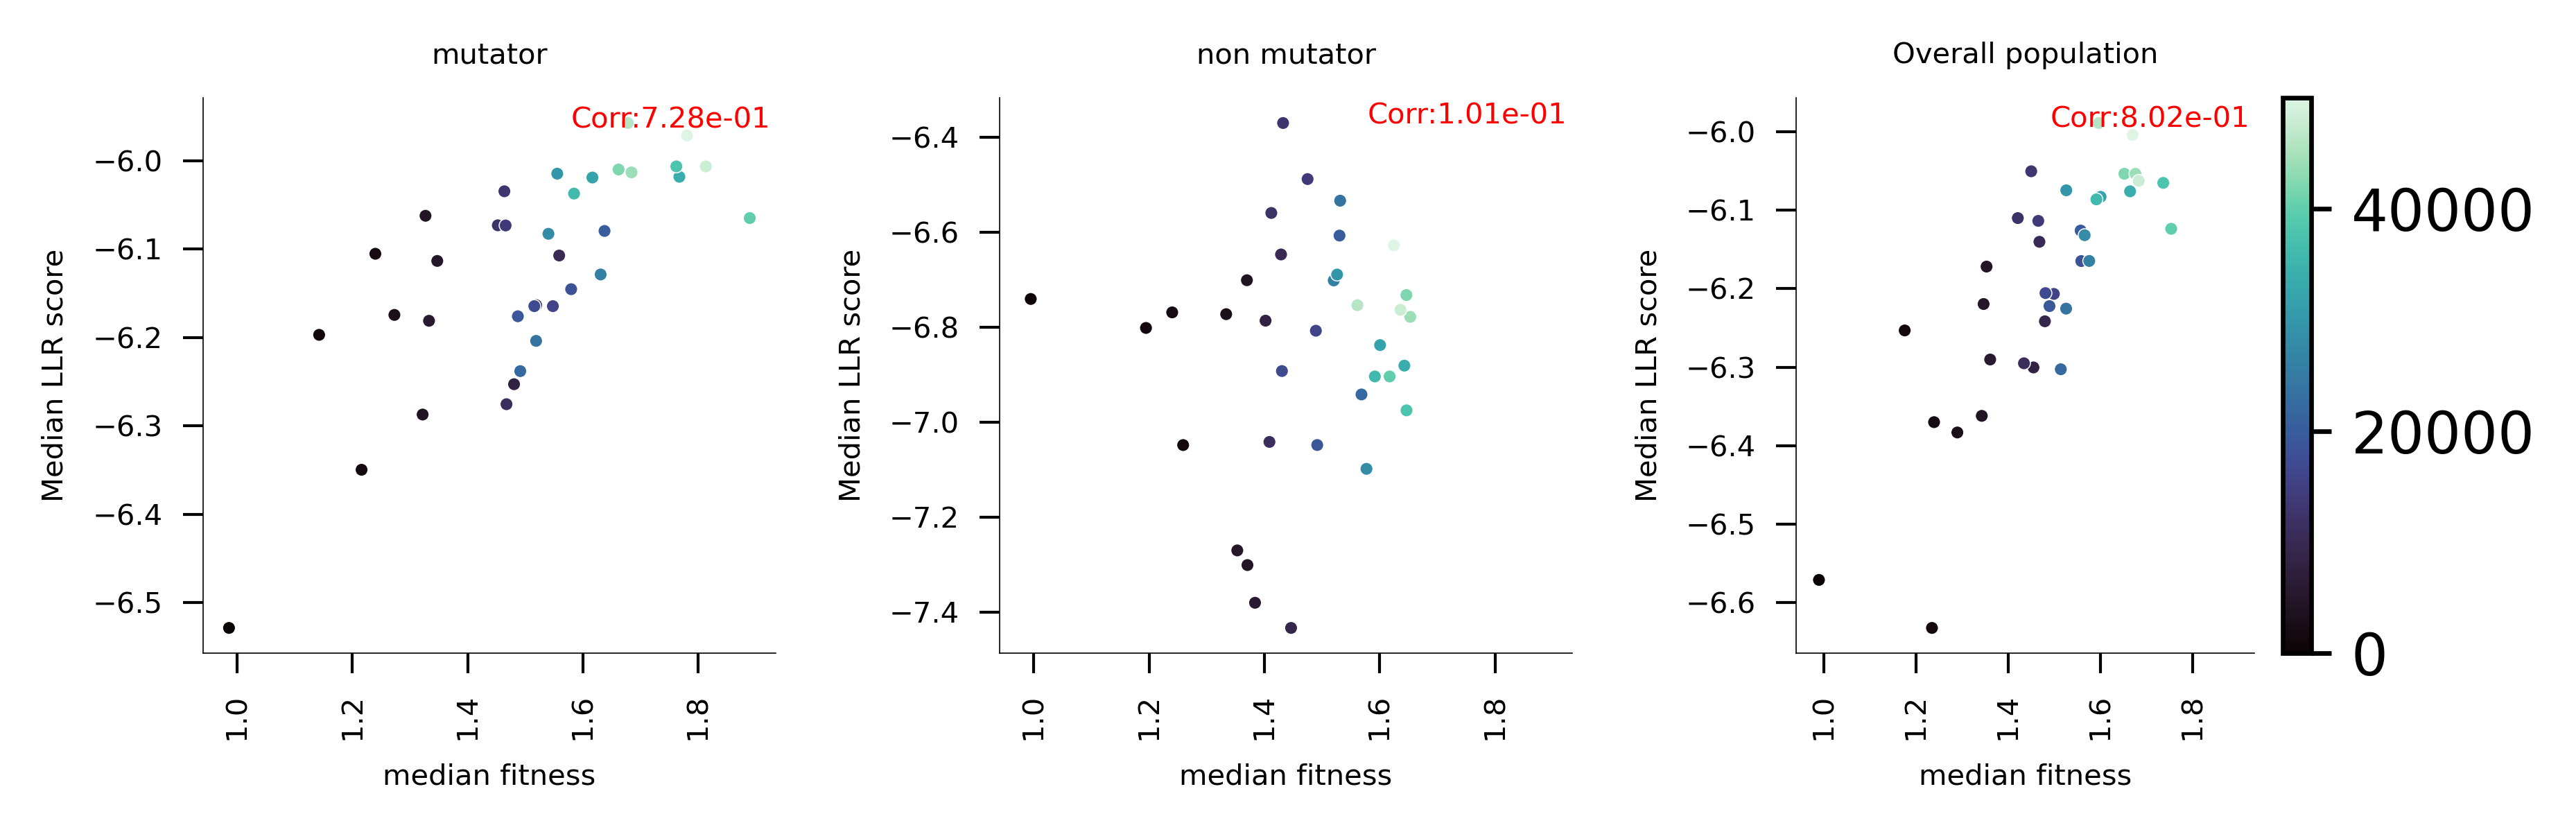

In [30]:
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
# sns.color_palette("mako", as_cmap=True)
norm = plt.Normalize(all_population_combined_esm_fitness_median['generation_number'].min(), all_population_combined_esm_fitness_median['generation_number'].max())
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
# sm.set_array([])
ax[0] = sns.scatterplot(data= mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[0], legend=True, s = 5, palette='mako')


ax[1] = sns.scatterplot(data= non_mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[1], legend=False, s = 5, palette='mako')

ax[2] = sns.scatterplot(data= all_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[2], legend=False, s = 5, palette='mako')

offset = 0.01

formatted_p_mutator = "{:.2e}".format(mutator_population_combined_esm_fitness_median["median fitness"].corr(mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[0].text((max(ax[0].get_xlim()) - offset), (max(ax[0].get_ylim()) - offset), "Corr:" + formatted_p_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_p_non_mutator = "{:.2e}".format(non_mutator_population_combined_esm_fitness_median["median fitness"].corr(non_mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[1].text((max(ax[1].get_xlim()) - offset), (max(ax[1].get_ylim()) - offset), "Corr:" + formatted_p_non_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_p_all = "{:.2e}".format(all_population_combined_esm_fitness_median["median fitness"].corr(all_population_combined_esm_fitness_median["median esm_score"]))
ax[2].text((max(ax[2].get_xlim()) - offset), (max(ax[2].get_ylim()) - offset), "Corr:" + formatted_p_all, fontsize=5, color='red', ha='right', va='top')


ax[0].set_title("mutator", fontsize=5)
ax[1].set_title("non mutator", fontsize=5)
ax[2].set_title("Overall population", fontsize=5)



for i in range(3):
    ax[i] = utility.custom_figure_axis(ax[i], fontsize=5, show_ticks = True)
    ax[i].set_ylabel("Median LLR score")

ax[0].get_legend().remove()
ax[0].figure.colorbar(sm)

plt.tight_layout()

<!-- #### esm score vs generation upto 60K -->

##### Generation vs fitness for mutator and non mutator category

###### It shows the line plots of the median fitness of mutators (six samples pooled) and non-mutators (six samples pooled) across 50,000 generations (Wiser, Ribeck, and Lenski 2013). Standard deviation of the fitness estimates is depicted by error bars. The composite trapezoidal rule is used for computing Area Under the Curve (AUC) associated with the fitness trajectories. Mutators display a marginally greater AUC in their fitness trajectory compared to non-mutators.

In [31]:
df_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="Yes"]
df_non_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="No"]
grouped_mutator_fitness = df_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_non_mutator_fitness = df_non_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]
grouped_non_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]

print("As per the trapezoidal rule, area under the mutator fitness curve across generation is : ", np.trapz(x = grouped_mutator_fitness["Generation"], y = grouped_mutator_fitness["Median fitness"]))
print("As per the trapezoidal rule, area under the non mutator fitness curve across generation is : ", np.trapz(x = grouped_non_mutator_fitness["Generation"], y = grouped_non_mutator_fitness["Median fitness"]))

As per the trapezoidal rule, area under the mutator fitness curve across generation is :  78356.80526875
As per the trapezoidal rule, area under the non mutator fitness curve across generation is :  75857.231003625


##### median fitness vs generation graph

###### It shows the line plots of the median fitness of mutators (six samples pooled) and non-mutators (six samples pooled) across 50,000 generations (Wiser, Ribeck, and Lenski 2013). Standard deviation of the fitness estimates is depicted by error bars. The composite trapezoidal rule is used for computing Area Under the Curve (AUC) associated with the fitness trajectories. Mutators display a marginally greater AUC in their fitness trajectory compared to non-mutators.

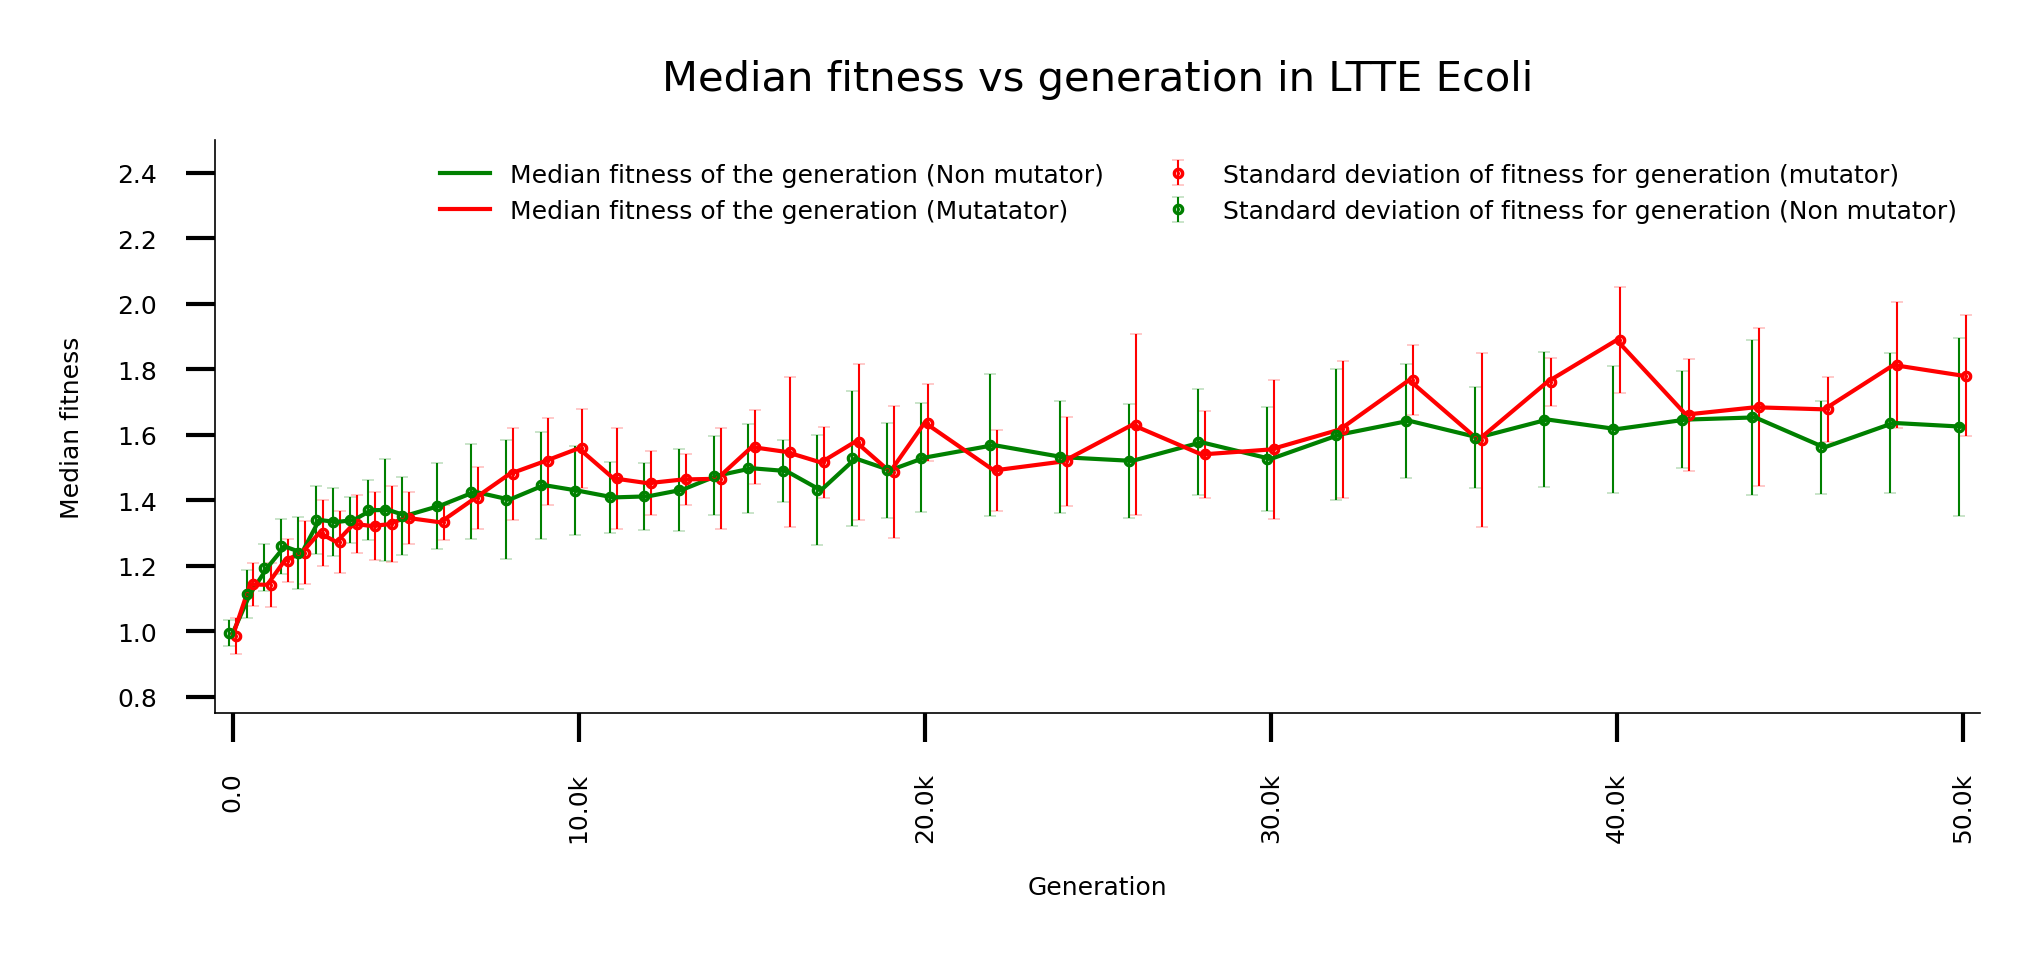

In [54]:
fig, ax = plt.subplots(1, 1 , dpi = 600, figsize = (3.5, 1.7))
from matplotlib.ticker import FuncFormatter

ax.errorbar(x = grouped_mutator_fitness["Generation"]+100, y = grouped_mutator_fitness["Median fitness"], yerr=grouped_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (mutator)', capthick=0.05, linewidth=0.25, color = "red", markersize=0.4)
ax.errorbar(x = grouped_non_mutator_fitness["Generation"]-100, y = grouped_non_mutator_fitness["Median fitness"], yerr=grouped_non_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (Non mutator)', capthick=0.05, linewidth=0.25, color ="green", markersize=0.4)
ax.plot(grouped_non_mutator_fitness["Generation"], grouped_non_mutator_fitness["Median fitness"], color = "green", label = "Median fitness of the generation (Non mutator)", lw = 0.5)
ax.plot(grouped_mutator_fitness["Generation"], grouped_mutator_fitness["Median fitness"], color ="red", label = "Median fitness of the generation (Mutatator)", lw = 0.5)
ax.legend(ncol=2, fontsize=3, frameon=False)
ax.set_ylim(0.75,2.5)
ax.set_xlim(-500,50500)
ax.set_ylabel("Median fitness")
ax.set_xlabel("Generation")
# Apply the custom tick formatter
formatter = FuncFormatter(utility.format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax = utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)

ax.set_title("Median fitness vs generation in LTTE Ecoli", fontsize=5)
plt.tight_layout()
# plt.savefig("Generation vs fitness in ecoli custom.pdf", dpi = 600, bbox_inches="tight")

##### divide the data in two group <=30K and >30K and calculate median esm score generation wise

In [33]:
grouped_gen_30K_median_esm = utility.return_generation_grouped_dataframe(all_mutation_with_esm_1b_score_drop_na, column_name = "esm_score", gen_cut_off = 30000, cut_off_string1 =  "<=30K", cut_off_string2 = ">30K")
grouped_gen_30K_median_esm.head()

generation_number      mutator  esm_score group_gen
0                  0      mutator  -6.528539     <=30K
1                  0  non mutator  -6.740957     <=30K
2               1000      mutator  -6.197031     <=30K
3               1000  non mutator  -6.801957     <=30K
4               1500      mutator  -6.349631     <=30K

##### box plot of esm score for mutator and non mutator while using 30K generation as cutoff group

###### As a binarized version of Figure 1(C), the boxplot shows the distribution of median LLR scores for generations split into two equal halves (each spanning approximately 30,000 generations). P-values are obtained using the one-sided Mann-Whitney U test. As expected, increase in median LLR score levels among non-mutators appear weaker as compared to mutators.

Text(0.5, 1.0, 'Median LLR score vs mutant type')

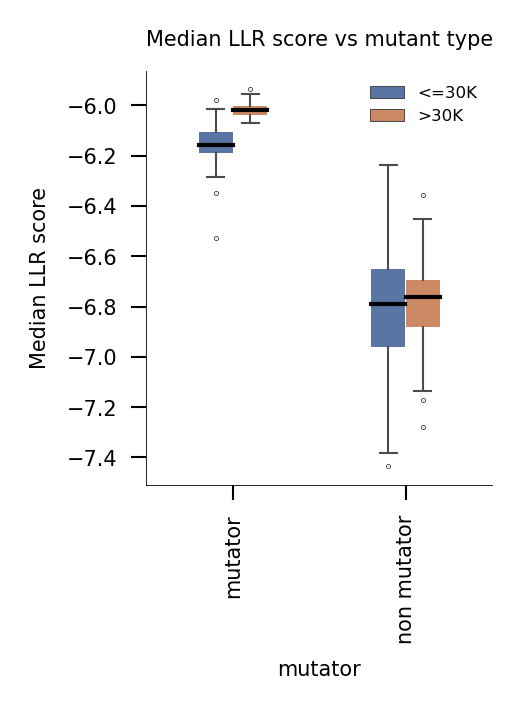

In [34]:
fig, ax = plt.subplots(1, 1 , dpi = 300, figsize = (2.1, 2.1), sharex=True)
sns.set_palette(sns.color_palette('deep'))
sns.boxplot(data=grouped_gen_30K_median_esm, x = "mutator", y = "esm_score", hue= "group_gen", dodge=20, ax = ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, medianprops={"color": "black","linewidth":1})
ax.legend(fontsize=4, frameon=False)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
ax.set_ylabel("Median LLR score")
ax.set_title("Median LLR score vs mutant type", fontsize = 5)
# plt.savefig("esm vs type in ecoli upto 60k gen.pdf", dpi = 600, bbox_inches="tight")

##### One sided mannwhitney test within the mutator groups for data points <=30K and >30K generation w.r.t esm score

In [35]:
mut_gen = grouped_gen_30K_median_esm[grouped_gen_30K_median_esm.loc[:, "mutator"]=="mutator"]
p_mut = utility.man_whiteney(mut_gen[mut_gen.loc[:, "group_gen"]==">30K"]["esm_score"], 
                                 mut_gen[mut_gen.loc[:, "group_gen"]=="<=30K"]["esm_score"])
print("The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t esm score is: ", str(p_mut))

The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t esm score is:  5.106678392961868e-16


##### One sided mannwhitney test within the non mutator groups for data points <=30K and >30K generation w.r.t esm score

In [36]:
non_mut_gen = grouped_gen_30K_median_esm[grouped_gen_30K_median_esm.loc[:, "mutator"]=="non mutator"]
p_non_mut = utility.man_whiteney(non_mut_gen[non_mut_gen.loc[:, "group_gen"]==">30K"]["esm_score"], 
                                 non_mut_gen[non_mut_gen.loc[:, "group_gen"]=="<=30K"]["esm_score"])
print("The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t esm score is: ", str(p_non_mut))

The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t esm score is:  0.19628716652263956


##### divide the data in two group <=30K and >30K and calculate median accumulated gain score generation wise

In [37]:
# all_mutation_with_esm_1b_score_drop_na[(all_mutation_with_esm_1b_score_drop_na.loc[:, "generation_number"]==1000) & (all_mutation_with_esm_1b_score_drop_na.loc[:, "mutator"]=="non mutator")]["AG"].median()

In [38]:
grouped_gen_30K_median_ag = utility.return_generation_grouped_dataframe(all_mutation_with_esm_1b_score_drop_na, column_name = "AG", gen_cut_off = 30000, cut_off_string1 =  "<=30K", cut_off_string2 = ">30K")
grouped_gen_30K_median_ag.head()

generation_number      mutator        AG group_gen
0                  0      mutator -3.851473     <=30K
1                  0  non mutator -5.438754     <=30K
2               1000      mutator -3.393951     <=30K
3               1000  non mutator -2.887487     <=30K
4               1500      mutator -3.388419     <=30K

##### box plot of accumulated gain for mutator and non mutator while using 30K generation as cutoff group

Text(0.5, 1.0, 'Median AG vs mutator type')

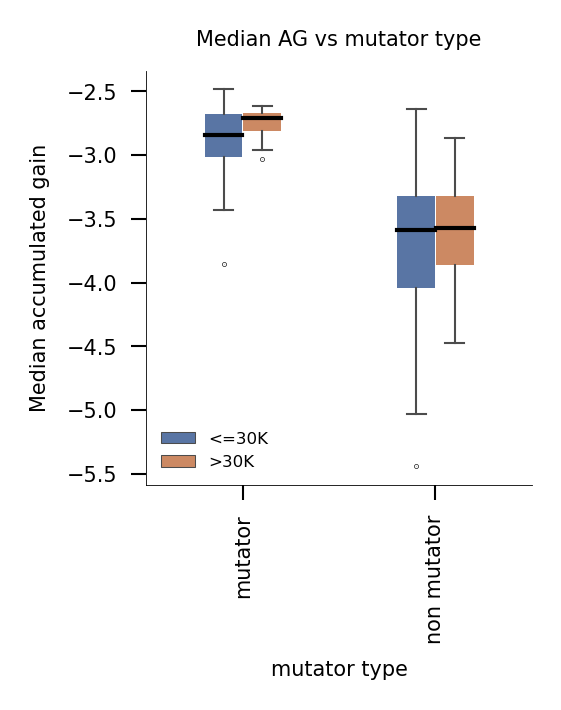

In [39]:
fig, ax = plt.subplots(1, 1 , dpi = 300, figsize = (2.1, 2.1), sharex=True)
sns.set_palette(sns.color_palette('deep'))
sns.boxplot(data=grouped_gen_30K_median_ag, x = "mutator", y = "AG", hue= "group_gen", dodge=20, ax = ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, medianprops={"color": "black","linewidth":1})
ax.legend(fontsize=4, frameon=False)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
ax.set_ylabel("Median accumulated gain")
ax.set_xlabel("mutator type")
ax.set_title("Median AG vs mutator type", fontsize = 5)
# plt.savefig("esm vs type in ecoli upto 60k gen.pdf", dpi = 600, bbox_inches="tight")

##### One sided mannwhitney test within the mutator groups for data points <=30K and >30K generation

In [40]:
mut_gen = grouped_gen_30K_median_ag[grouped_gen_30K_median_ag.loc[:, "mutator"]=="mutator"]
p_mut = utility.man_whiteney(mut_gen[mut_gen.loc[:, "group_gen"]==">30K"]["AG"], 
                                 mut_gen[mut_gen.loc[:, "group_gen"]=="<=30K"]["AG"])
print("The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t accumulated gain is: ", str(p_mut))

The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t accumulated gain is:  0.008735814180085223


##### One sided mannwhitney test within the non mutator groups for data points <=30K and >30K generation

In [41]:
non_mut_gen = grouped_gen_30K_median_ag[grouped_gen_30K_median_ag.loc[:, "mutator"]=="non mutator"]
p_non_mut = utility.man_whiteney(non_mut_gen[non_mut_gen.loc[:, "group_gen"]==">30K"]["AG"], 
                                 non_mut_gen[non_mut_gen.loc[:, "group_gen"]=="<=30K"]["AG"])
print("The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t accumulated gain is: ", str(p_non_mut))

The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t accumulated gain is:  0.23344514133584293


##### divide df_allele_generation data (containing gain as well as allele count) in mutator and non mutator sub dataframe

In [42]:
df_mutator_full = df_allele_generation[df_allele_generation['label'].isin(mutator_list)]
df_non_mutator_full = df_allele_generation[df_allele_generation['label'].isin(non_mutator_list)]

##### Accumulated gain vs population for unique mutation

###### The figure presents a box plot depicting the accumulated gain for each population based on the data. The visual evidence show that, without exception, all mutators consistently exhibit a higher median accumulated gain score compared to non-mutators.

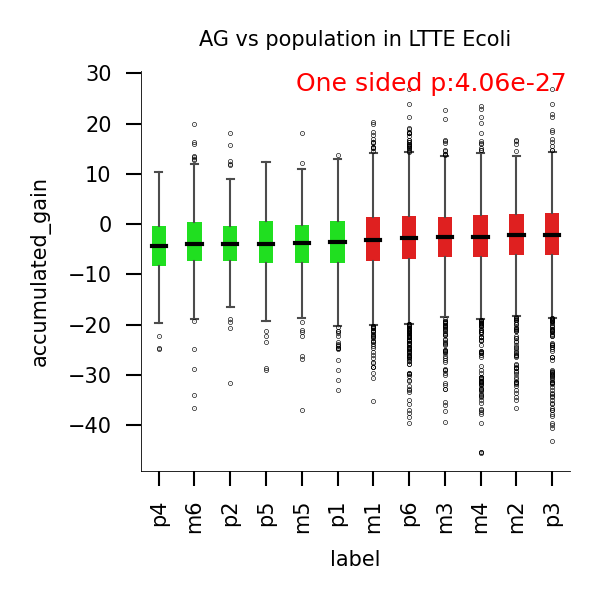

In [43]:
fig, ax = plt.subplots(1, 1, dpi = 300, figsize =(2.1,2.1))
colors = ["lime", "lime", "lime", "lime", "lime", "lime", "red", "red", "red", "red", "red", "red"]
sns.set_palette(sns.color_palette(colors), n_colors=len(colors))
# colors = ["green", "green", "green", "green", "green", "green", "red", "red", "red", "red", "red", "red"]
ax = utility.box_plot(data= df_allele_generation, x = 'label', y = 'accumulated_gain', ax = ax)

ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
offset = 0.1
formatted_p = "{:.2e}".format(utility.man_whiteney(df_mutator_full["accumulated_gain"], df_non_mutator_full["accumulated_gain"]))
ax.text((max(ax.get_xlim()) - offset), (max(ax.get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=6, color='red', ha='right', va='top')
ax.set_title("AG vs population in LTTE Ecoli", fontsize=5)
plt.tight_layout()
sns.set_palette(sns.color_palette('deep'))

# plt.savefig("ag vs population in ecoli.pdf", dpi = 600, bbox_inches="tight")

##### Allele change vs accumulated gain for unique mutation 
###### The figure shows a box plot depicting the accumulated gain for each allele change.

In [44]:
df_allele_generation["Allele"]= df_allele_generation["Allele"].str.strip()
allele_switch_group1 = ['C->G','A->C','A->T','T->G','G->C','T->A', 'C->A',  'G->T'] # Transversion group
allele_switch_group2 = ['G->A', 'C->T', 'A->G','T->C'] # Transition group
df_allele_switch_group1 = df_allele_generation[df_allele_generation["Allele"].isin(allele_switch_group1)]
df_allele_switch_group2 = df_allele_generation[df_allele_generation["Allele"].isin(allele_switch_group2)]

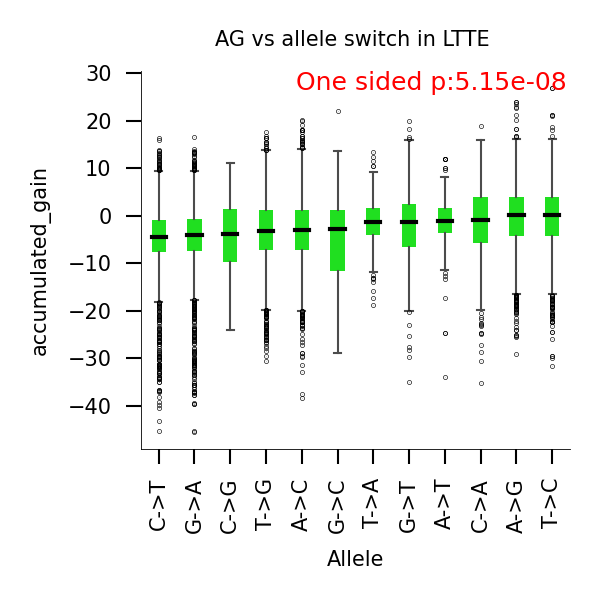

In [45]:
fig, ax = plt.subplots(1, 1, dpi = 300, figsize =(2.1,2.1))
colors = ["lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime"]
sns.set_palette(sns.color_palette(colors), n_colors=len(colors))
ax = utility.box_plot(data= df_allele_generation, x = 'Allele', y = 'accumulated_gain', ax = ax)
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
offset = 0.1
formatted_p = "{:.2e}".format(utility.man_whiteney(df_allele_switch_group2['accumulated_gain'], df_allele_switch_group1['accumulated_gain']))
ax.text((max(ax.get_xlim()) - offset), (max(ax.get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=6, color='red', ha='right', va='top')

ax.set_title("AG vs allele switch in LTTE ", fontsize=5)
plt.tight_layout()
sns.set_palette(sns.color_palette('deep'))

# plt.savefig("accumulated gain vs allele change in ecoli.pdf", dpi = 600, bbox_inches="tight")

##### Median Accumulated gain vs generation line plot with 95% confidence interval
###### It shows the line plot of median of accumulated gain vs generation where the the shaaded region indicate 95% confident interval around median for both mutator and non mutator and overall.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(4.4583333333333215, 0.5, 'Median AG')

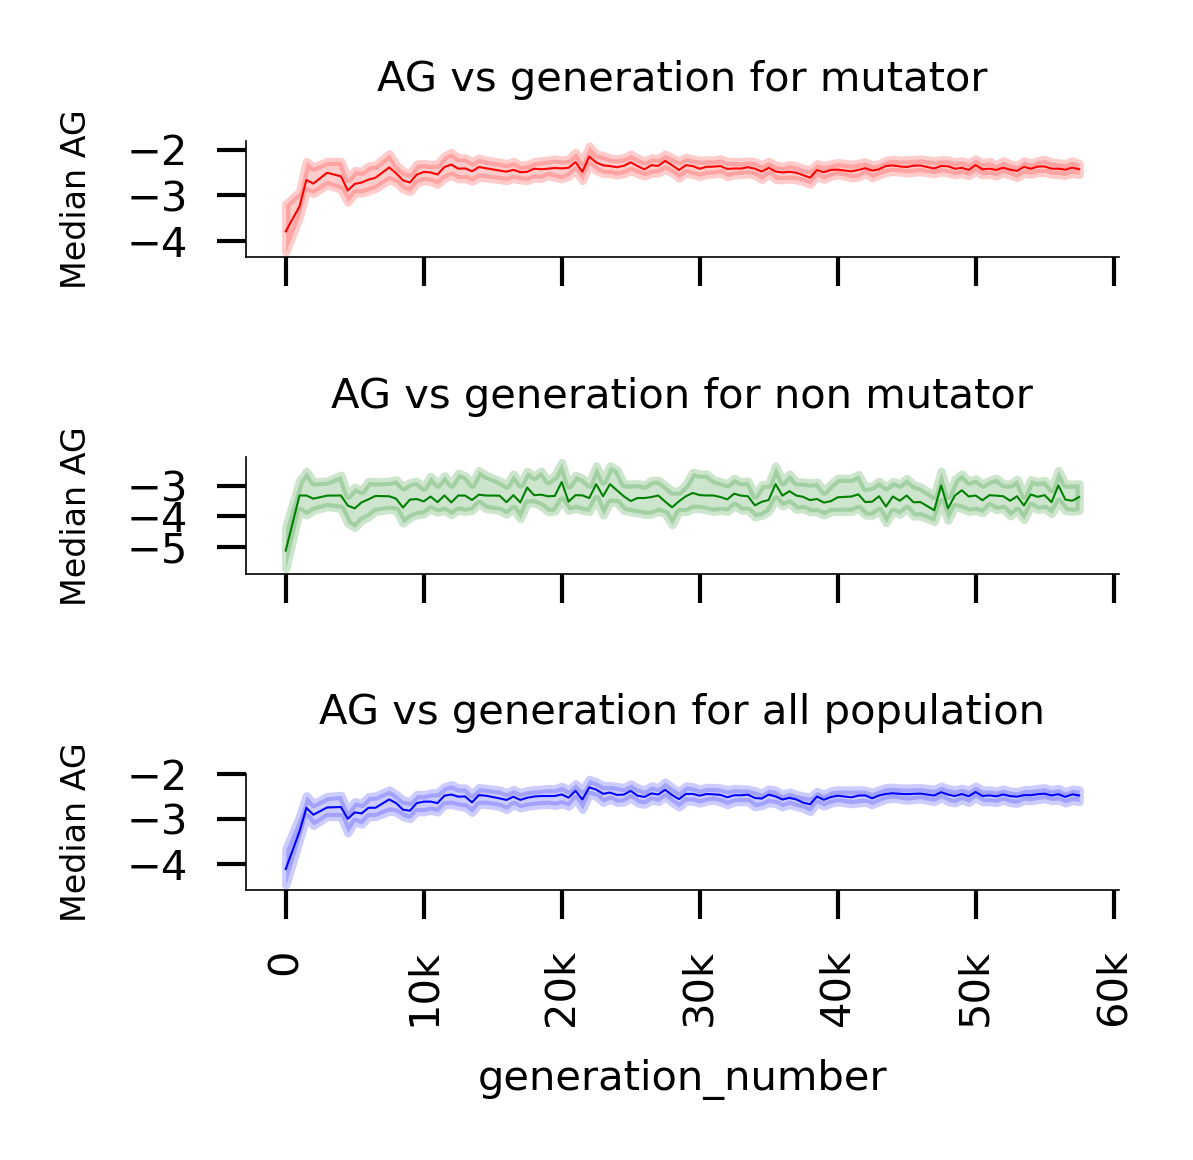

In [46]:
ax = utility.return_mutator_non_mutator_column_name_wise_graph_together(all_mutation, mutator_list, non_mutator_list, column_name = "AG", fontsize = 5);

for i in range(3):
    ax[i] = utility.custom_figure_axis(ax[i], fontsize=5, show_ticks = True);
    ax[i].set_xticks(range(0, 60001, 10000));
#     ax[i].set_title(None)
    
ax[0].set_yticks(np.arange(-4, -1.9, 1));
ax[1].set_yticks(np.arange(-5, -2.4, 1));
ax[2].set_yticks(np.arange(-4, -1.9, 1));
ax[0].set_ylabel("Median AG", fontsize=4)
ax[1].set_ylabel("Median AG", fontsize=4)
ax[2].set_ylabel("Median AG", fontsize=4)
# plt.savefig("ag vs generation in ecoli custom1.pdf", dpi = 600, bbox_inches="tight")

##### Divide the data in accumulated gain quantile wise

In [47]:
lst_quantile_accumulated_gain_vs_allele, lst_quantile_accumulated_gain_vs_allele_only, lst_quantile_accumulated_gain_vs_allele_median =  utility.return_data_quantile_wise(all_mutation, column_name ="AG")
ag_quantile_wise_allele_count = utility.return_quantile_wise_allele_count(lst_quantile_accumulated_gain_vs_allele, column_name="AG")

In [48]:
ag_quantile_wise_allele_count

quantile of AG  AC  log10(AC)         AG label
13                0-5%   1   0.000000 -24.901836    p1
14                0-5%   1   0.000000 -13.907580    p1
21                0-5%   1   0.000000 -16.076905    p1
44                0-5%   1   0.000000 -19.382214    p2
73                0-5%   1   0.000000 -17.865371    p3
...                ...  ..        ...        ...   ...
1048476        95-100%   1   0.000000  19.945541    m6
1048488        95-100%   4   0.602060   8.627822    m6
1048519        95-100%   1   0.000000  11.842248    m6
1048574        95-100%  81   1.908485   8.264352    m6
1048584        95-100%   5   0.698970   8.867295    m6

[1048647 rows x 5 columns]

##### sanity check to verify that all the ag quantile range are non overlapping from visual prospective

<Axes: xlabel='AG', ylabel='Density'>

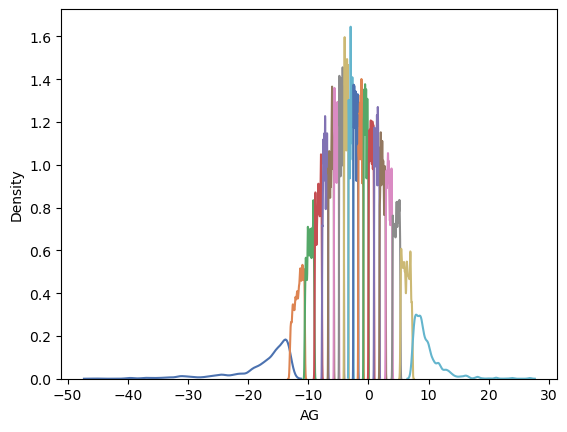

In [49]:
import seaborn as sns
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="0-5%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="5-10%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="10-15%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="15-20%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="20-25%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="25-30%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="30-35%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="35-40%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="40-45%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="45-50%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="50-55%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="55-60%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="60-65%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="65-70%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="70-75%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="75-80%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="80-85%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="85-90%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="90-95%"]["AG"])
sns.kdeplot(ag_quantile_wise_allele_count[ag_quantile_wise_allele_count.loc[:, "quantile of AG"]=="95-100%"]["AG"])

##### log10(AC) vs quantile of AG score

In [50]:
lst_quantile_accumulated_gain_vs_allele[0]

label CHROM  Position   Gene Allele   Annotation generation  \
13         p1  chrI   1507570   yddH   C->A     nonsense       AC:0   
14         p1  chrI   1902586   yebZ   C->T   synonymous       AC:0   
21         p1  chrI   2496379   ypfE   T->G   synonymous       AC:0   
44         p2  chrI   1125981   mdoH   C->T     nonsense       AC:0   
73         p3  chrI     93844   ftsL   C->T   synonymous       AC:0   
...       ...   ...       ...    ...    ...          ...        ...   
1048538    m6  chrI   1813572   ynjB   G->C     missense   AC:57500   
1048542    m6  chrI   2095621   yegB   G->A   synonymous   AC:57500   
1048548    m6  chrI   2397135  yfcTU   T->G     missense   AC:57500   
1048576    m6  chrI   3359332   yrdD   G->T     missense   AC:57500   
1048631    m6  chrI   4266390    acs   C->A    noncoding   AC:57500   

                AG  allele count  generation_number  
13      -24.901836             1                  0  
14      -13.907580             1                  0  
21      -16.076905             1                  0  
44      -19.382214             1                  0  
73      -17.865371             1                  0  
...            ...           ...                ...  
1048538 -17.852194            13              57500  
1048542 -36.510711            56              57500  
1048548 -13.305429             1              57500  
1048576 -14.663045            32              57500  
1048631 -13.522576           107              57500  

[52427 rows x 10 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The p value between first 0-50% quantile and rest is :  1.51e-235


Text(19.4, 2.4178370091056394, 'One sided p:1.51e-235')

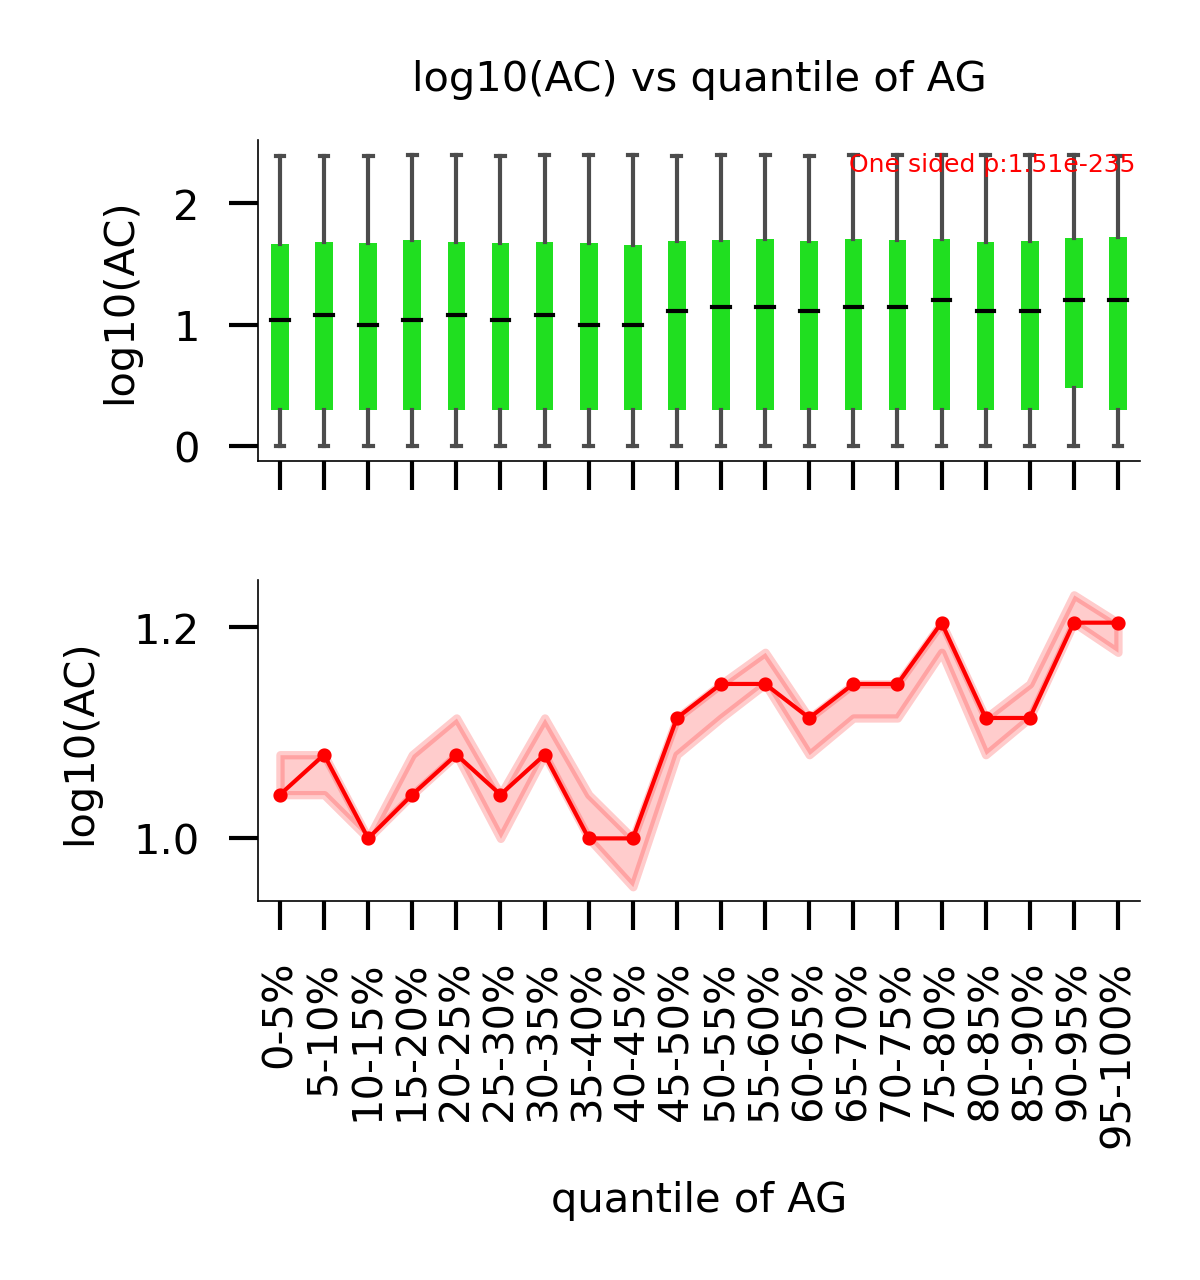

In [51]:
fig, ax = plt.subplots(2, 1 , dpi = 600, figsize = (2.1, 2.1), sharex=True)
ax = utility.plot_ac_vs_column(ax=ax, data = ag_quantile_wise_allele_count, lst_quantile_dataframe_column_name_median = lst_quantile_accumulated_gain_vs_allele_median, show_ticks = True, fontsize=5, column_name = "AG")
ax[0].set_title("log10(AC) vs quantile of AG", fontsize=5)
formatted_p = utility.return_quantile_wise_pvalue(lst_quantile_accumulated_gain_vs_allele);
ax[0].text((max(ax[0].get_xlim()) - offset), (max(ax[0].get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=3, color='red', ha='right', va='top')
# plt.savefig("ecoli log10(AC) vs quantile wise AG lineplot.pdf", dpi = 600, bbox_inches="tight")

##### Divide the data in esm score quantile wise

In [52]:
lst_quantile_esm_score_vs_allele, lst_quantile_esm_score_vs_allele_only, lst_quantile_esm_score_vs_allele_median =  utility.return_data_quantile_wise(all_mutation_with_esm_1b_score_drop_na, column_name ="esm_score")
esm_score_quantile_wise_allele_count = utility.return_quantile_wise_allele_count(lst_quantile_esm_score_vs_allele, column_name="esm_score")

##### log10(AC) vs quantile of esm score

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


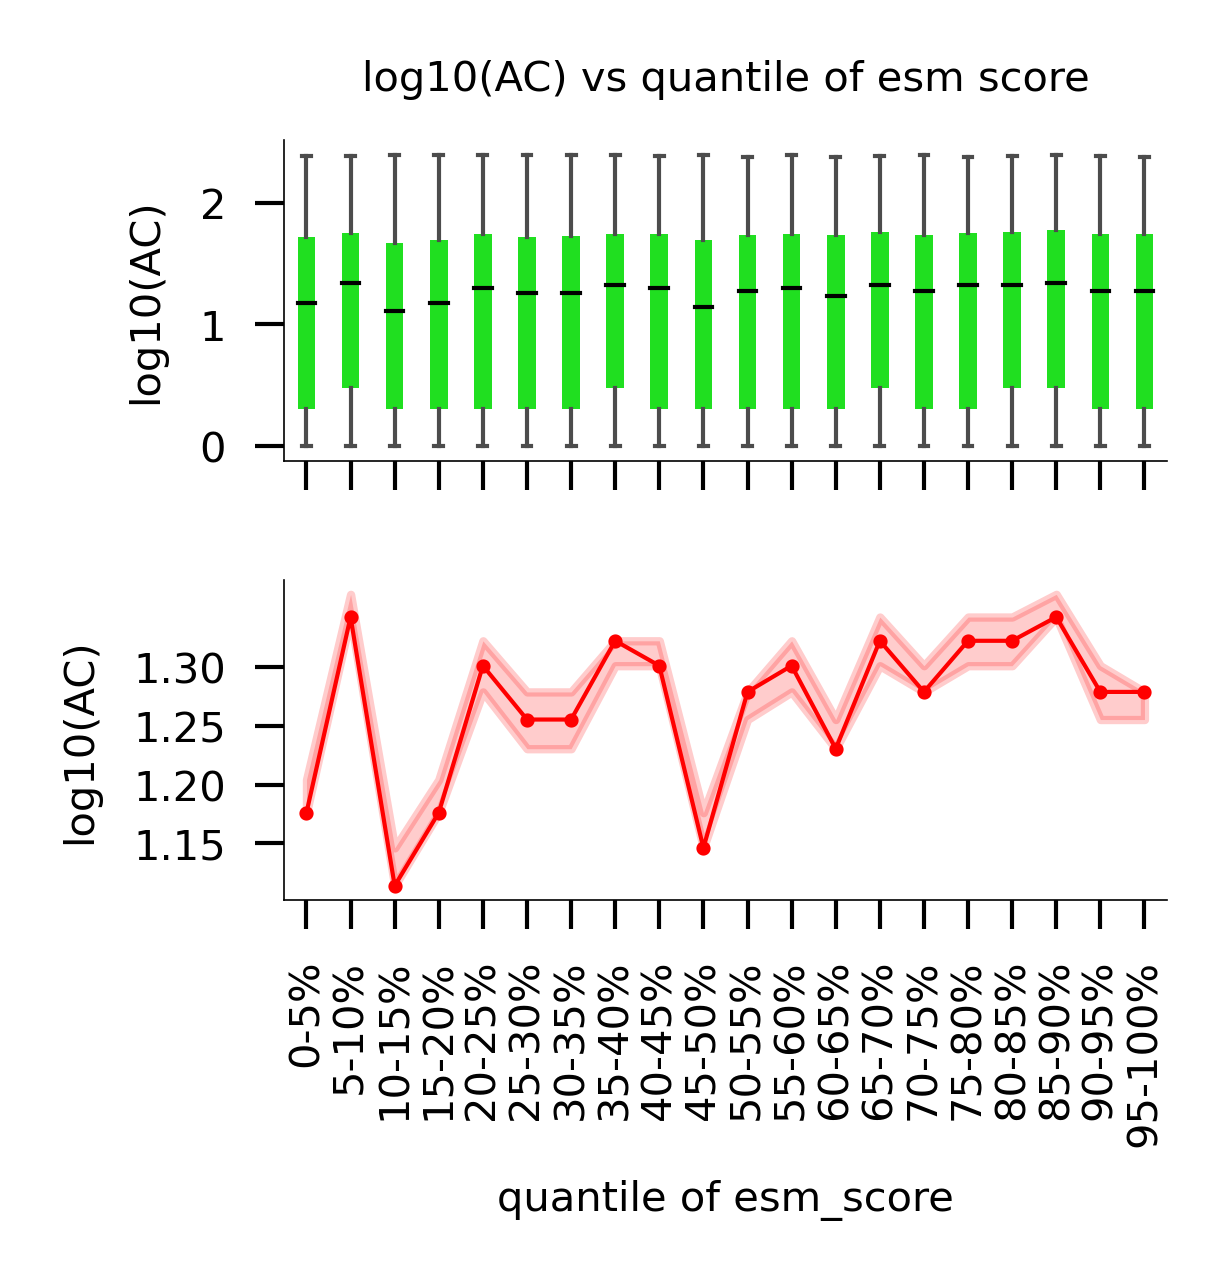

In [53]:
fig, ax = plt.subplots(2, 1 , dpi = 600, figsize = (2.1, 2.1), sharex=True)
ax = utility.plot_ac_vs_column(ax=ax, data = esm_score_quantile_wise_allele_count, lst_quantile_dataframe_column_name_median = lst_quantile_esm_score_vs_allele_median, show_ticks = True, fontsize=5, column_name = "esm_score")
ax[0].set_title("log10(AC) vs quantile of esm score", fontsize=5)
# ax[1].set_ylabel("Median of log10(AC)")
offset = 0.1
ax[1].set_yticks(np.arange(1.15, 1.31, 0.05))
# formatted_p = utility.return_quantile_wise_pvalue(lst_quantile_esm_score_vs_allele);
# ax[0].text((max(ax[0].get_xlim()) - offset), (max(ax[0].get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=3, color='red', ha='right', va='top')
# plt.savefig("ecoli log10(AC) vs quantile wise esm score lineplot.pdf", dpi = 600, bbox_inches="tight")